# Datamining 7331 Lab 2: Analysis of Airbnb data using Classification and Regression

By: William Arnost, Stephen Johnson, Sean Kennedy, Tazeb Abera

## Introduction

In this notebook we will be predicting the room type and price features from the Airbnb data set using different algorithms. 

Room type can take 3 values: 'Private room', 'Entire home/apt', and 'Shared room'. We will drop shared room and focus on the other two classes. Room type by itself might not be a useful thing to predict, but we are hoping this can teach us something about our data for a future price prediction exercise. 

[Describe Price]

[Describe other main topics]

## Contents
<link1>
<link2>
<...>

## Data Preparation Part 1

### Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

### Package Loading

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import pickle
%matplotlib inline
#sns.set(style="ticks", color_codes=True)
# sklearn stuff
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier


#yellobrick stuff
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Define Functions for model analysis

In [400]:
def compare_classifiers(
                        clf_1
                      , clf_2
                      , title_1
                      , title_2
                      , X_train
                      , X_test
                      , y_train
                      , y_test):
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
    
    yb_confusion_matrix(clf_1
                   , X_train
                   , X_test
                   , y_train
                   , y_test
                   , ax=ax[0][0])
    
    yb_confusion_matrix(clf_2
                   , X_train
                   , X_test
                   , y_train
                   , y_test
                   , ax=ax[0][1])
    ax[0][0].set_title(f'Confusion Matrix: {title_1}')
    ax[0][1].set_title(f'Confusion Matrix: {title_2}')
    
    yb_class_report(clf_1
                   , X_train
                   , X_test
                   , y_train
                   , y_test
                   , ax=ax[1][0])
    yb_class_report(clf_2
                   , X_train
                   , X_test
                   , y_train
                   , y_test
                   , ax=ax[1][1])
    ax[1][0].set_title(f'Class Report: {title_1}')
    ax[1][1].set_title(f'Class Report: {title_2}')
    
    score_1 = yb_roc_auc(clf_1
                   , X_train
                   , X_test
                   , y_train
                   , y_test
                   , ax=ax[2][0])
    
    score_2 = yb_roc_auc(clf_2
                   , X_train
                   , X_test
                   , y_train
                   , y_test
                   , ax=ax[2][1])
    ax[2][0].set_title(f'ROC/AUC: {title_1} - {score_1}')
    ax[2][1].set_title(f'ROC/AUC: {title_2} - {score_2}')
    
    yb_recall(clf_1
                   , X_train
                   , X_test
                   , y_train
                   , y_test
                   , ax=ax[3][0])
    
    yb_recall(clf_2
                   , X_train
                   , X_test
                   , y_train
                   , y_test
                   , ax=ax[3][1])
    ax[3][0].set_title(f'Precision/Recall: {title_1}')
    ax[3][1].set_title(f'Precision Recall: {title_2}')
    fig.tight_layout()
    try:
        print(pd.DataFrame({title_1:clf_1.steps[0][1].coef_[0]
              ,title_2: clf_2.steps[0][1].coef_[0]}
              ,index=X_train.columns))
    except:
        print(pd.DataFrame({title_1:clf_1.steps[0][1].feature_importances_
              ,title_2: clf_2.steps[0][1].feature_importances_}
              ,index=X_train.columns))

def yb_confusion_matrix(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='Response',
                       classes=[0, 1],
                       ax=None):
    matrix = ConfusionMatrix(model, classes=classes, ax=ax)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.finalize()
    
def yb_class_report(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='Response',
                       classes=[0, 1],
                       ax=None):
    class_report = ClassificationReport(model, classes=classes, support=True, ax=ax)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.finalize()
    
def yb_roc_auc(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='Response',
                       classes=[0, 1],
                       ax=None):
    roc_auc = ROCAUC(model, classes=classes, ax=ax)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.finalize()
    return roc_auc.score_
    
def yb_recall(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='Response',
                       classes=[0, 1],
                       ax=None):
    recall = PrecisionRecallCurve(model, ax=ax)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.finalize()
    
def analyze_classifier(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='Response',
                       classes=[0, 1]):
    matrix = ConfusionMatrix(model, classes=classes)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, classes=classes, support=True)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model, classes=classes)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    recall = PrecisionRecallCurve(model)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    #if len(classes) == 2:
    #    disc_thresh = DiscriminationThreshold(model)
    #    disc_thresh.fit(X_train, y_train.values.ravel())
    #    disc_thresh.show()
    #    return disc_thresh.thresholds_, disc_thresh.cv_scores_
    #else:
    #    return None, None


    
    
def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        #print(exog)
        not_exog = [i for i in exogs if i != exog]
        #print(not_exog)
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    #create a df of predictions and probabilities
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([
        pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']),
        predictions
    ],
                                axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(
        lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={
        0: 'No_Predicted',
        1: 'Yes_Predicted'
    },
                  index={
                      0: 'No_True',
                      1: 'Yes_True'
                  },
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),
                 5), matrix, predicted_probs


def transform_data(data):
    #OH encode
    label_encode = [
        x for x, y in dict(data.dtypes).items()
        if type(y) == pd.CategoricalDtype
    ]
    for var in label_encode:
        #impute to Mode
        print(f"{var} was OHE'd")
        data[var].fillna(data[var].mode()[0], inplace=True)
        cat_list = pd.get_dummies(data[var], prefix=var)
        data_new = data.join(cat_list)
        data = data_new

    normalize = [x for x, y in dict(data.dtypes).items() if y == np.float64]
    for col in normalize:
        #change impution scheme?
        print(f"{col} was Standard Scaled")
        data[col].fillna(data[col].median(), inplace=True)
        normalizer = StandardScaler()
        ar_train = data[col].to_numpy().reshape(-1, 1)
        normalizer.fit(ar_train)
        data.loc[:, col] = normalizer.transform(ar_train)
    
    data.drop(columns=label_encode, inplace=True)
    data.drop(columns=target_col, inplace=True)
    
    return data

### Read in the data

In [92]:
data = pd.read_csv('ABNB_NY_V2.csv')
summary = data.describe()
print({x: len(data[x].unique()) for x in data.columns})
summary

{'id': 48895, 'name': 47897, 'host_id': 37457, 'host_name': 11453, 'neighbourhood_group': 5, 'neighbourhood': 221, 'latitude': 19048, 'longitude': 14718, 'room_type': 3, 'price': 674, 'minimum_nights': 109, 'number_of_reviews': 394, 'last_review': 1765, 'reviews_per_month': 938, 'calculated_host_listings_count': 47, 'availability_365': 366, 'ZIP': 199, 'dist_subway': 46157, 'cnt_all': 133, 'cnt_entire_home': 95, 'cnt_private_room': 74, 'cnt_shared_room': 14, 'avgprice_all': 1912, 'avgprice_entire_home': 1409, 'avgprice_private_room': 1309, 'avgprice_shared_room': 219}


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ZIP,dist_subway,cnt_all,cnt_entire_home,cnt_private_room,cnt_shared_room,avgprice_all,avgprice_entire_home,avgprice_private_room,avgprice_shared_room
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48871.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,10675.111211,0.245997,52.815768,29.719726,22.013396,1.082646,152.703409,191.493067,98.024409,40.581520
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,599.591915,0.346640,43.303548,29.254144,18.668278,2.615105,90.678742,114.468382,73.981026,93.479089
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,10001.000000,0.000553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,10024.000000,0.103457,20.000000,8.000000,7.000000,0.000000,94.812500,137.250000,64.500000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,11104.000000,0.173022,43.000000,20.000000,17.000000,0.000000,135.208333,180.850000,83.666667,0.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,11221.000000,0.269066,73.000000,42.000000,33.000000,1.000000,189.000000,231.264463,111.500000,60.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,11697.000000,4.931115,230.000000,142.000000,91.000000,26.000000,5000.000000,5000.000000,3000.000000,1800.000000


### Type Conversion

In [93]:
data['price'] = data['price'].astype('float')
data['minimum_nights'] = data['minimum_nights'].astype('float')
data['number_of_reviews'] = data['number_of_reviews'].astype('float')
data['calculated_host_listings_count'] = data[
    'calculated_host_listings_count'].astype('float')
data['availability_365'] = data['availability_365'].astype('float')
data['dist_subway'] = data['dist_subway'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_entire_home'] = data['cnt_entire_home'].astype('float')
data['cnt_private_room'] = data['cnt_private_room'].astype('float')
data['cnt_shared_room'] = data['cnt_shared_room'].astype('float')
data['avgprice_all'] = data['avgprice_all'].astype('float')
data['avgprice_entire_home'] = data['avgprice_entire_home'].astype('float')
data['avgprice_private_room'] = data['avgprice_private_room'].astype('float')
data['avgprice_shared_room'] = data['avgprice_shared_room'].astype('float')
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['neighbourhood'] = data['neighbourhood'].astype('category')
data['ZIP'] = data['ZIP'].astype('category')
data['last_review'] = pd.to_datetime(data['last_review'])

data['days_since_last_review'] = (
    dt.datetime.strptime('2020-01-01', '%Y-%m-%d') -
    data['last_review']).dt.days
data.days_since_last_review.fillna(data.days_since_last_review.max(),
                                   inplace=True)
data.drop(columns=['last_review'], inplace=True)

### Remove Outliers

In [94]:
data = data[data.price != 0].copy()
data = data[data.price < 300].copy()
data = data[data.minimum_nights <= 20].copy()

In [95]:
idx = data[data['room_type'] == 'Shared room'].index
data.drop(idx , inplace=True)

### Encode Target Variable

In [96]:
target_col = 'room_type'
room_types = {'Entire home/apt': 0, 'Private room': 1}
data['Response'] = data.apply(lambda x: room_types[x.room_type], axis=1)

### Drop Columns that won't be used in modeling

In [97]:
data.drop(
    columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'ZIP'],
    inplace=True)

### Feature / Target Split

In [101]:
data_final = data
features, target = data_final.drop(
    columns=['Response']), data_final.loc[:, ['Response']]
features.shape, target.shape


((39156, 20), (39156, 1))

## Modeling and Evaluation 1

- Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.


## Modeling and Evaluation 2

- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.


### Train Test Split

- For classification, we will start with a simple **5-fold StratifiedShuffleSplit 80/20** train/test split of our data. In this case we are looking to ensure that our classes are balanced (i.e have the same probability of being observed in train/test as they do in the dataset as a whole). The **StratifiedShuffleSplit** object in sklearn is designed to maintain class balance across all folds. From the **Yellowbrick ClassBalance** bar charts below, we can see that our classes are nearly perfectly balanced in our training and testing sets across all folds.


- After each train/test split is created, we will transform the data (OHE and normalization/impution) before passing the train/test sets to the classifier.

neighbourhood_group was OHE'd
latitude was Standard Scaled
longitude was Standard Scaled
price was Standard Scaled
minimum_nights was Standard Scaled
number_of_reviews was Standard Scaled
reviews_per_month was Standard Scaled
calculated_host_listings_count was Standard Scaled
availability_365 was Standard Scaled
dist_subway was Standard Scaled
cnt_all was Standard Scaled
cnt_entire_home was Standard Scaled
cnt_private_room was Standard Scaled
cnt_shared_room was Standard Scaled
avgprice_all was Standard Scaled
avgprice_entire_home was Standard Scaled
avgprice_private_room was Standard Scaled
avgprice_shared_room was Standard Scaled
days_since_last_review was Standard Scaled


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_subway,cnt_all,...,avgprice_all,avgprice_entire_home,avgprice_private_room,avgprice_shared_room,days_since_last_review,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
count,3.915600e+04,3.915600e+04,3.915600e+04,3.915600e+04,3.915600e+04,3.915600e+04,3.915600e+04,3.915600e+04,3.915600e+04,3.915600e+04,...,3.915600e+04,3.915600e+04,3.915600e+04,3.915600e+04,3.915600e+04,39156.000000,39156.000000,39156.000000,39156.000000,39156.000000
mean,-5.484011e-14,-3.649977e-14,-1.239056e-15,-9.341281e-15,-1.377979e-14,2.731844e-15,-3.067563e-14,-2.596988e-15,-3.341273e-16,-6.300450e-16,...,-1.384603e-16,3.255163e-16,-4.185637e-16,-1.677980e-16,-9.414156e-16,0.024466,0.443866,0.397078,0.126085,0.008504
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,...,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,0.154494,0.496845,0.489299,0.331950,0.091828
min,-4.050101e+00,-6.234785e+00,-1.711933e+00,-7.314254e-01,-5.524281e-01,-8.350048e-01,-1.024010e-01,-7.707260e-01,-6.928070e-01,-1.197383e+00,...,-1.922846e+00,-1.790393e+00,-1.444397e+00,-4.160263e-01,-6.787305e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.018090e-01,-6.648105e-01,-7.921138e-01,-7.314254e-01,-5.312905e-01,-6.659219e-01,-1.024010e-01,-7.707260e-01,-4.065712e-01,-7.738219e-01,...,-6.827535e-01,-4.706031e-01,-4.483926e-01,-4.160263e-01,-6.641950e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.400807e-01,-8.449378e-02,-2.595870e-01,-3.822119e-01,-4.044649e-01,-3.340184e-01,-1.024010e-01,-5.919028e-01,-2.157466e-01,-2.090743e-01,...,-2.477906e-01,-1.151281e-01,-1.935281e-01,-4.160263e-01,-5.697147e-01,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.360124e-01,3.573005e-01,5.472719e-01,3.162149e-01,3.942491e-02,3.047392e-01,-5.156531e-02,6.679877e-01,4.491166e-02,4.497980e-01,...,4.552893e-01,3.799106e-01,2.081932e-01,1.801737e-01,2.624390e-01,0.000000,1.000000,1.000000,0.000000,0.000000
max,3.307916e+00,4.982736e+00,2.951711e+00,5.903630e+00,1.274313e+01,3.579336e+01,1.647003e+01,2.196113e+00,1.267076e+01,4.214782e+00,...,1.662374e+01,4.759883e+01,4.546318e+01,1.967433e+01,2.068467e+00,1.000000,1.000000,1.000000,1.000000,1.000000


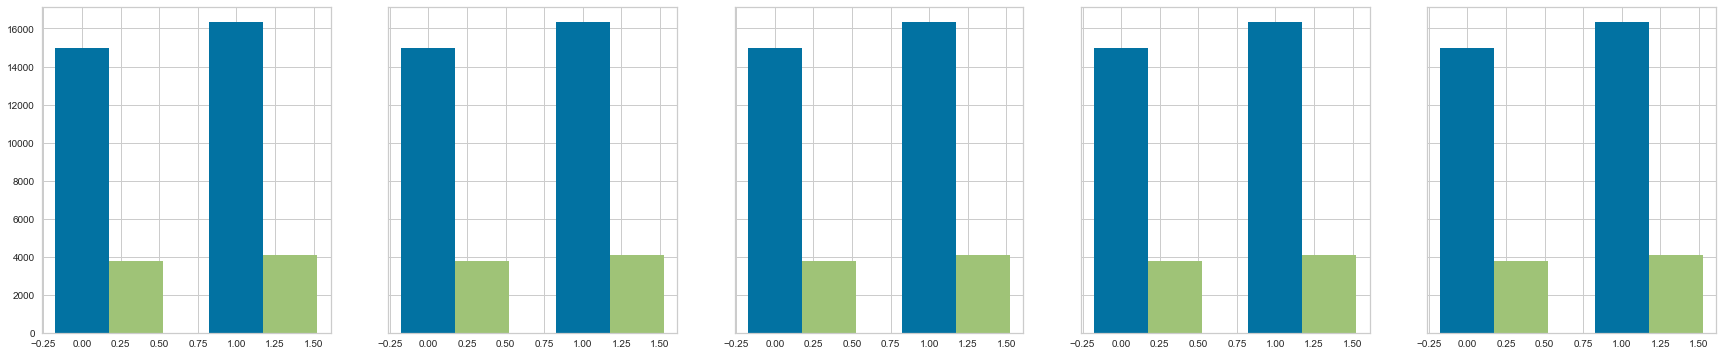

In [125]:
n_splits = 5
cv = StratifiedShuffleSplit(n_splits,test_size=.2, train_size=.8, random_state=random_state)
support = []
fold = 0
features_xform = transform_data(features)
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(30, 6))
all_train = []
all_test = []
for trainidx, testidx in cv.split(features, target):
    X_train = features_xform.iloc[trainidx] 
    X_test = features_xform.iloc[testidx] 
    y_train = target.iloc[trainidx]
    y_test = target.iloc[testidx]
    classes_test = ClassBalance(labels=['Entire home/apt', 'Private room'], ax=ax[fold])
    classes_test.fit(y_train['Response'], y_test['Response'])
    support.append(classes_test.support_)
    [all_train.append(x) for x in trainidx]
    [all_test.append(x) for x in testidx]
    fold = fold + 1
    #print(f'{len(X_train)}, {len(y_train)}')
    #print(f'{len(X_test)}, {len(y_test)}')
    
all_train_features = features_xform.iloc[all_train]
all_train_target = target.iloc[all_train]
all_test_features = features_xform.iloc[all_test]
all_test_target = target.iloc[all_test]
features_xform.describe()

## Modeling and Evaluation 3

- Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

## Classification Modeling

### Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

- Compare baseline accuracy to parameter-tuned accuracy for a **LogisticRegression** classifier. The baseline model will have minimal regularization applied (l2/ridge is the sklearn default) since we will use a very high value for C as a default. We will also set a default value for max_iter=1000 so that algorithms terminate in a timely fashion. All models will also be fit with an intercept.


- We will tune the following parameters:
     
     - **penalty**: *values [l1, l2]* this paramter indicates what type of regression penalty will be applied (lasso or ridge)  
 
     - **C**: *values [1e-4 to 1e+4]*  the inverse strength of the regularization penalty dictates the amount of penalization that will be applied for more complex models. A lower value implies a higher penalty.

- We will also run cross validation for multiple scoring metrics (AUC, F1 and Accuracy) but the best estimator will be selected based on AUC

In [103]:
scoring = {
            'Accuracy':'accuracy'
            , 'F-1 Score':'f1'
            , 'AUC':'roc_auc'}

#### Baseline Logistic Regression Model (No Tuning)

In [334]:
logistic = LogisticRegression(
    fit_intercept=True # always fit an intercept term
    ,max_iter=1000
    ,n_jobs=-1 # use all processors
    ,C=1e6
    ,penalty='l2'
)
pipe = Pipeline(steps=[('logistic', logistic)])
clf_logistic = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {'logistic__random_state':[random_state]}
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='AUC'
                   , error_score=0.0)
baseline_logistic_fit = clf_logistic.fit(features_xform, target.values.ravel())
print(f'Best Estimator {baseline_logistic_fit.best_estimator_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Best Estimator Pipeline(memory=None,
     steps=[('logistic', LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=5,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])


#### Hyper-parameter tuned Logistic Regression model

In [335]:
grid_search_C = np.logspace(-4, 4, 4)
grid_search_class_weight = [None, 'balanced']
grid_search_penalty = ['l1', 'l2', 'none']
grid_search_multi_class = ['auto', 'ovr', 'multinomial']
grid_search_dual = [True, False]
grid_search_solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
print(f'C: {grid_search_C}')
print(f'class_weight: {grid_search_class_weight}')
print(f'penalty: {grid_search_penalty}')
print(f'multi_class: {grid_search_multi_class}')
print(f'dual: {grid_search_dual}')
print(f'solver: {grid_search_solver}')

C: [1.00000000e-04 4.64158883e-02 2.15443469e+01 1.00000000e+04]
class_weight: [None, 'balanced']
penalty: ['l1', 'l2', 'none']
multi_class: ['auto', 'ovr', 'multinomial']
dual: [True, False]
solver: ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']


In [342]:
logistic = LogisticRegression(
     max_iter=1000
    ,fit_intercept=True # always fit an intercept term
    ,n_jobs=-1 # use all processors
    ,random_state=random_state
)
pipe = Pipeline(steps=[('logistic', logistic)])

param_grid = [{
    'logistic__C': grid_search_C,
    'logistic__class_weight':grid_search_class_weight,
    'logistic__penalty':grid_search_penalty,
    'logistic__multi_class':grid_search_multi_class,
    'logistic__dual':grid_search_dual,
    #'logistic__solver':grid_search_solver
}]
clf_logistic_tuned = GridSearchCV(pipe
                   , param_grid=param_grid
                   , cv=cv
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='AUC'
                   , error_score=0.0)
tuned_logistic_fit = clf_logistic_tuned.fit(features_xform, target.values.ravel())
pickle.dump(tuned_logistic_fit, open('tuned_logistic_fit.p', 'wb'))
print(tuned_logistic_fit.best_estimator_)
pd.DataFrame(tuned_logistic_fit.cv_results_).head()

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 419 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.0min finished
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipeline(memory=None,
     steps=[('logistic', LogisticRegression(C=21.54434690031882, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='auto', n_jobs=-1, penalty='l1', random_state=5,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__class_weight,param_logistic__dual,param_logistic__multi_class,param_logistic__penalty,params,...,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,split3_train_AUC,split4_train_AUC,mean_train_AUC,std_train_AUC
0,0.037683,0.005248,0.000000,0.000000,0.0001,None,True,auto,l1,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.000000,0.000000,49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.264754,0.004792,0.032912,0.012761,0.0001,None,True,auto,l2,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.879112,0.003309,33,0.878341,0.879224,0.877774,0.877384,0.879393,0.878423,0.000786
2,0.015281,0.001591,0.000000,0.000000,0.0001,None,True,auto,none,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.000000,0.000000,49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.089942,0.067355,0.000000,0.000000,0.0001,None,True,ovr,l1,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.000000,0.000000,49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.348516,0.033934,0.028170,0.007269,0.0001,None,True,ovr,l2,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.879112,0.003309,33,0.878341,0.879224,0.877774,0.877384,0.879393,0.878423,0.000786
5,0.011898,0.004746,0.000000,0.000000,0.0001,None,True,ovr,none,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.000000,0.000000,49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.032229,0.008754,0.000000,0.000000,0.0001,None,True,multinomial,l1,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.000000,0.000000,49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.037514,0.022966,0.000000,0.000000,0.0001,None,True,multinomial,l2,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.000000,0.000000,49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.017016,0.009005,0.000000,0.000000,0.0001,None,True,multinomial,none,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.000000,0.000000,49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.105746,0.009256,0.038850,0.007596,0.0001,None,False,auto,l1,"{'logistic__C': 0.0001, 'logistic__class_weigh...",...,0.500000,0.000000,45,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


### Random Forest Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- Compare baseline accuracy to parameter-tuned accuracy for a **RandomForestClassifier**. We will use a default value for max_depth=10 to prevent overfitting.

- We will tune the following parameters:
    - **n_estimators**: *values [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]* the sklearn default is 100 trees/estimators. 
    - **max_features**: *values [6, 11, 16, 21]* controls the number of features factored into calculating the best split

- We will also run cross validation for multiple scoring metrics (AUC, F1 and Accuracy)

- Additionally, the RF Classifier will give feature importance

#### Baseline RF Classifier (no tuning)

In [346]:
random_forest = RandomForestClassifier(
    n_jobs=-1, # use all processors,
    max_depth=10 #should be set to prevent overfitting
)
pipe = Pipeline(steps=[('random_forest', random_forest)])
clf_rf = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {'random_forest__random_state':[random_state]}
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='AUC'
                   , error_score=0.0)
baseline_rf_fit = clf_rf.fit(features_xform, target.values.ravel())
print(f'Best Estimator {baseline_rf_fit.best_estimator_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Best Estimator Pipeline(memory=None,
     steps=[('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=5, verbose=0, warm_start=False))])


#### Tuned RF Classifier

In [349]:
n_estimators= list(range(10, 200, 10))
max_features = list(range(6, len(features_xform.columns), 5))
print(f'n_estimator_grid_search:{n_estimators}')
print(f'max_features_grid_search:{max_features}')

n_estimator_grid_search:[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
max_features_grid_search:[6, 11, 16, 21]


In [350]:
random_forest = RandomForestClassifier(
    n_jobs=-1, # use all processors
    max_depth=10
)
pipe = Pipeline(steps=[('random_forest', random_forest)])
clf_rf_tuned = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {'random_forest__random_state':[random_state],
                                 'random_forest__n_estimators': n_estimators,
                                 'random_forest__max_features': max_features}
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='AUC'
                   , error_score=0.0)
tuned_rf_fit = clf_rf_tuned.fit(features_xform, target.values.ravel())
print(f'Best Estimator {tuned_rf_fit.best_estimator_}')
### should check more leaf paramters to prevent overfitting (see XGB Params)

Fitting 5 folds for each of 76 candidates, totalling 380 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed: 16.1min finished


Best Estimator Pipeline(memory=None,
     steps=[('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=-1,
            oob_score=False, random_state=5, verbose=0, warm_start=False))])


### Gradient Boost Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

- Compare baseline accuracy to parameter-tuned accuracy for a **GradientBoostClassifier**

- We will tune the paramters as follows:
    - **loss**: *values ['deviance', 'exponential']* - deviance corresponds to LogisticRegression, exponential corresponds to AdaBoost. AdaBoost (adaptive boosting) is a method that allows weak learners to learn from the prior misclassifications of other weak learners. AdaBoost is designed to prevent overfitting.
    
    - **learning_rate**: *values [0.1, 0.2]*
    
    - **min_sample_split**: *value will be set to 1% of total sample size*
    
    - **max_features**: *values [sqrt]*
    
    - **subsample**: *values [0.8]*

- We will also run cross validation for multiple scoring metrics (AUC, F1 and Accuracy)

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/


#### Baseline XGBoost Classifier (No Tuning)

In [352]:
xg_boost = GradientBoostingClassifier(
    #n_jobs=-1, # use all processors,
)
pipe = Pipeline(steps=[('xg_boost', xg_boost)])
clf_xgboost = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {'xg_boost__random_state':[random_state]}
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='AUC'
                   , error_score=0.0)
baseline_xgboost_fit = clf_xgboost.fit(features_xform, target.values.ravel())
print(f'Best Estimator {baseline_xgboost_fit.best_estimator_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Best Estimator Pipeline(memory=None,
     steps=[('xg_boost', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1,...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])


#### Tuned XGBoost Classifier

In [357]:
grid_search_loss = ['deviance', 'exponential']
grid_search_learning_rate = [0.1, 0.2]
grid_search_min_samples_split = [int(round(features_xform.shape[0] * 0.01, 0))] #should be about 1% of samples
grid_search_max_features = ['sqrt']
grid_search_subsample = [0.8]

In [358]:
xg_boost = GradientBoostingClassifier(
    #n_jobs=-1, # use all processors,
)
pipe = Pipeline(steps=[('xg_boost', xg_boost)])
clf_xgboost_tuned = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {'xg_boost__random_state':[random_state]
                                  ,'xg_boost__loss': grid_search_loss #deviance = logistic, exponential = adaBoost
                                  , 'xg_boost__learning_rate': grid_search_learning_rate
                                  , 'xg_boost__min_samples_split': grid_search_min_samples_split
                                  , 'xg_boost__max_features':grid_search_max_features
                                  , 'xg_boost__subsample':grid_search_subsample
                    }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='AUC'
                   , error_score=0.0)
tuned_xgboost_fit = clf_xgboost_tuned.fit(features_xform, target.values.ravel())
print(f'Best Estimator {tuned_xgboost_fit.best_estimator_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.3s finished


Best Estimator Pipeline(memory=None,
     steps=[('xg_boost', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='exponential', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_le...    subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])


## Modeling and Evaluation 4

- Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

### Comparing Untuned vs CV-Tuned Models

#### Logistic Regression

- By increasing the regularization strength (lowering C from 1e6 to 21.54) and switching the regularization penalty to l1 (lasso regression) we were able to achieve a marginal increase in our AUC score 0.90738 (tuned) vs 0.90727 (untuned). 

- The models chosen by each process were very similar with respect to the continuous variables, but regularization did significantly change the values associate with out categorical variable (neighbourhood group)

- Our goal was to increase AUC, which was accomplished - but not as much as we could have given the number of parameters available for tuning in the LogisticRegression model.

Pipeline(memory=None,
     steps=[('logistic', LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=5,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])
Pipeline(memory=None,
     steps=[('logistic', LogisticRegression(C=21.54434690031882, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='auto', n_jobs=-1, penalty='l1', random_state=5,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])
                                   Baseline Logistic  Tuned Logistic
latitude                                   -0.007241       -0.006840
longitude                                  -0.265511       -0.268894
price                                      -2.557020       -2.578977
minimum_nights                             -0.353575       -0.353286
number_of

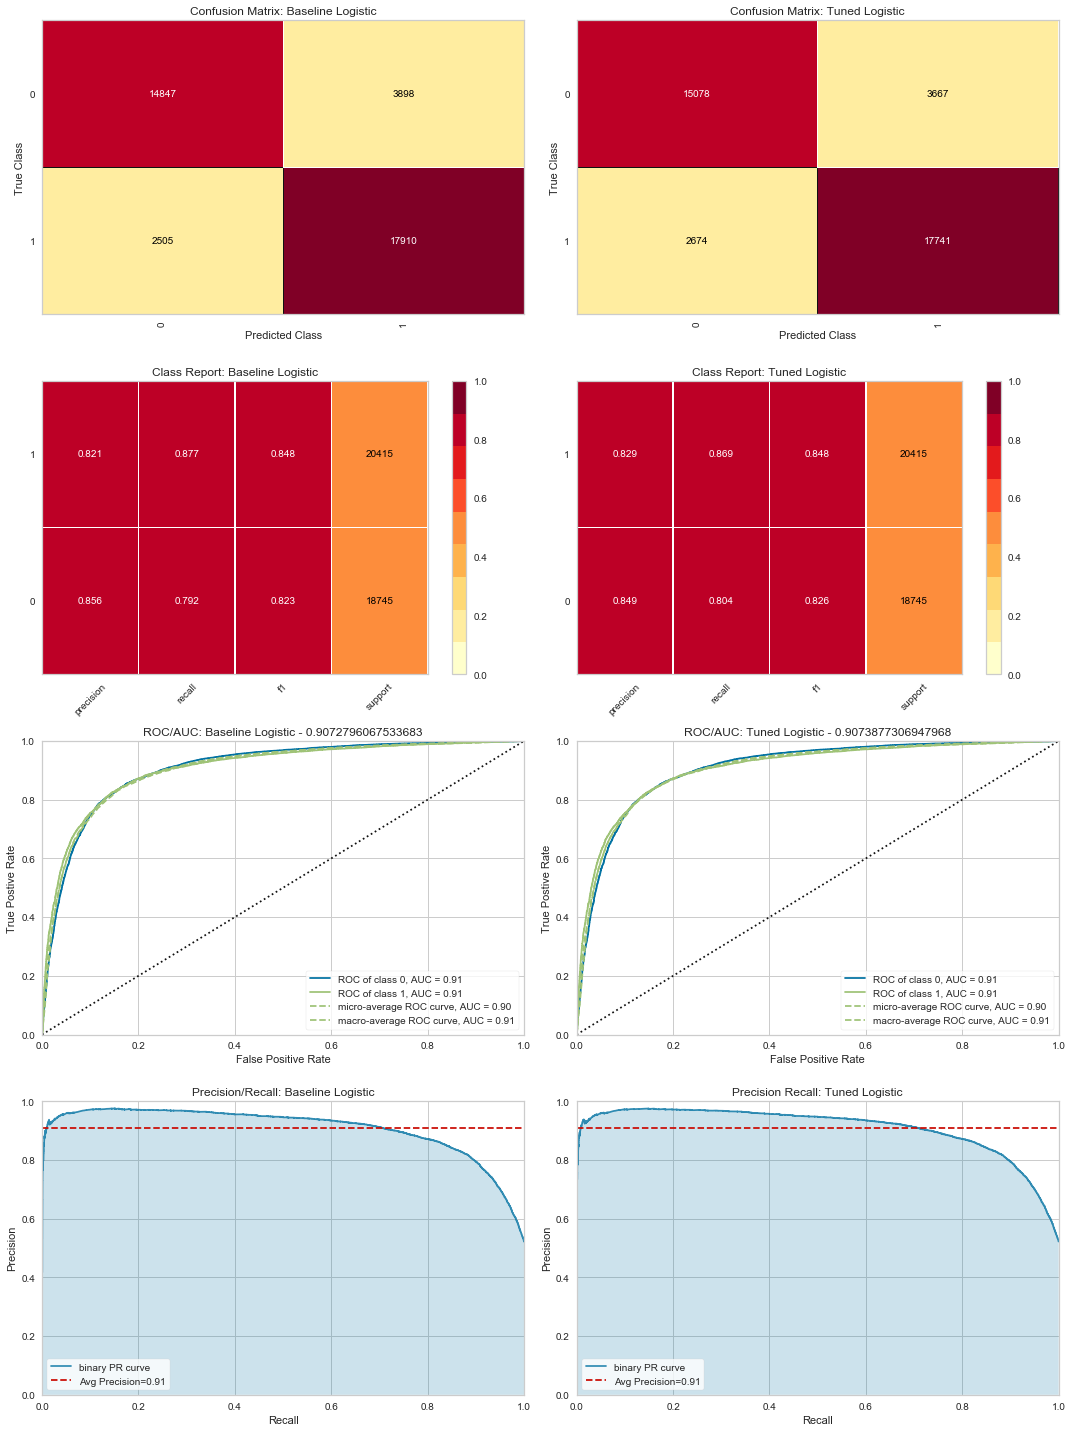

In [402]:
print(baseline_logistic_fit.best_estimator_)
print(tuned_logistic_fit.best_estimator_)
compare_classifiers(
     baseline_logistic_fit.best_estimator_
    , tuned_logistic_fit.best_estimator_
    , 'Baseline Logistic'
    , 'Tuned Logistic'
    , all_train_features
    , all_test_features
    , all_train_target
    , all_test_target)                 

Pipeline(memory=None,
     steps=[('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=5, verbose=0, warm_start=False))])
Pipeline(memory=None,
     steps=[('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=-1,
            oob_score=False, random_state=5, verbose=0, warm_start=False))])
                                   Baseline RF  Tuned RF
latitude                  

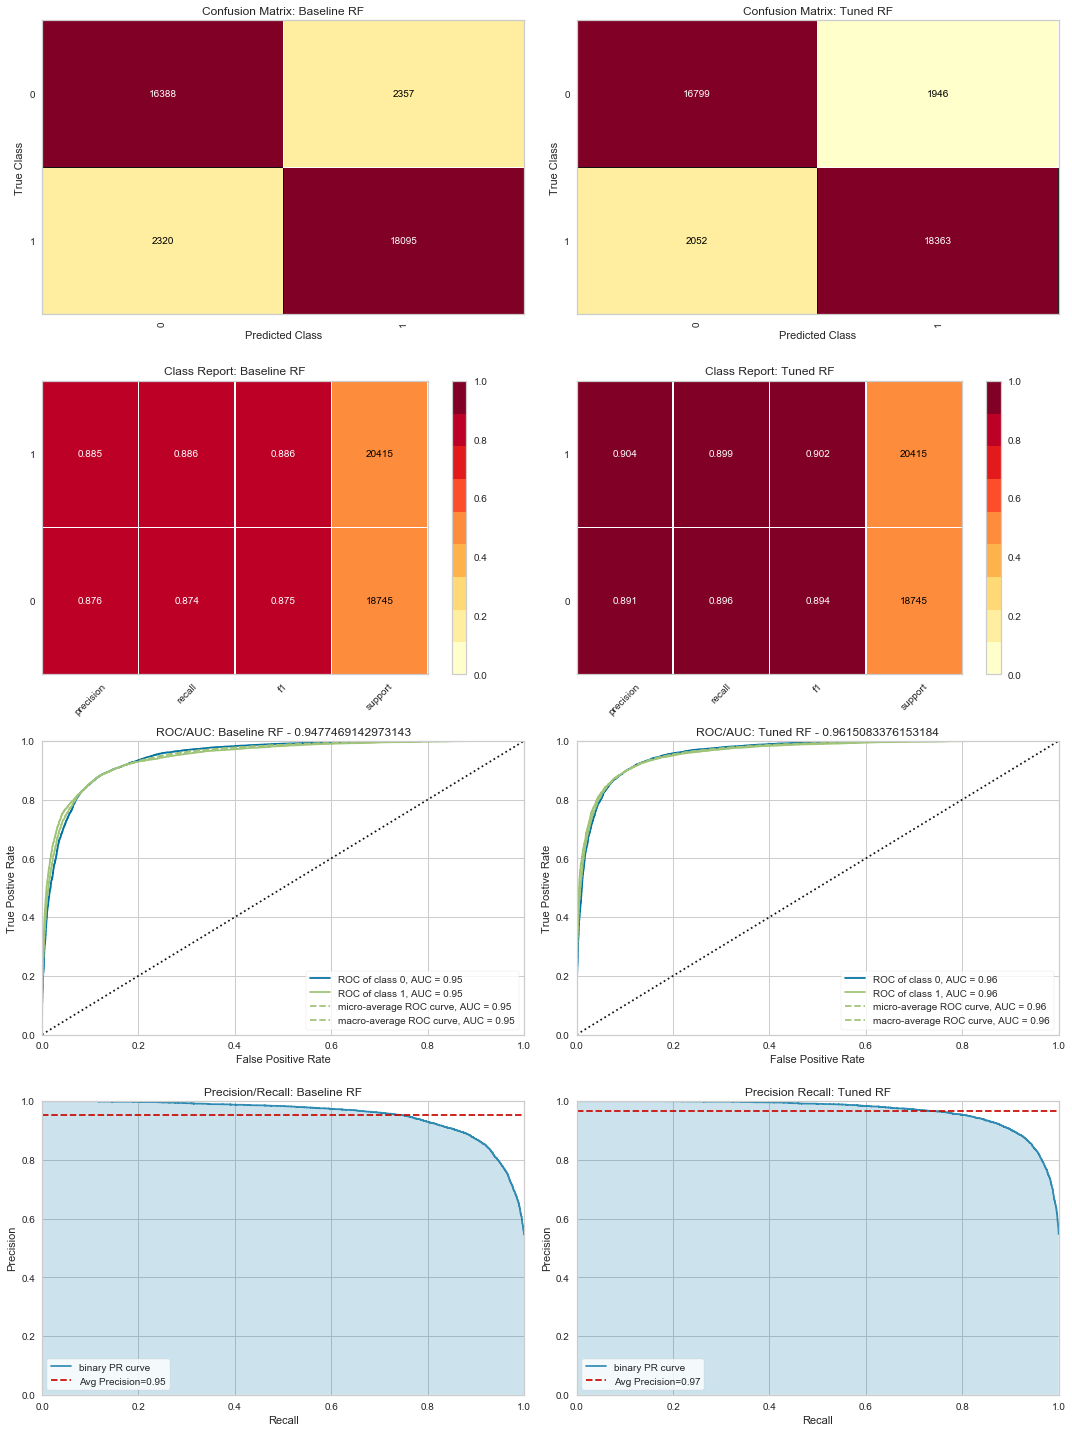

In [403]:
print(baseline_rf_fit.best_estimator_)
print(tuned_rf_fit.best_estimator_)
compare_classifiers(
     baseline_rf_fit.best_estimator_
    , tuned_rf_fit.best_estimator_
    , 'Baseline RF'
    , 'Tuned RF'
    , all_train_features
    , all_test_features
    , all_train_target
    , all_test_target)  

Pipeline(memory=None,
     steps=[('xg_boost', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1,...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])
Pipeline(memory=None,
     steps=[('xg_boost', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='exponential', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_le...    subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])
                                   Baseline XGBoost  Tuned XGBoost
latitude                               7.554981e-03       0.013600
lo

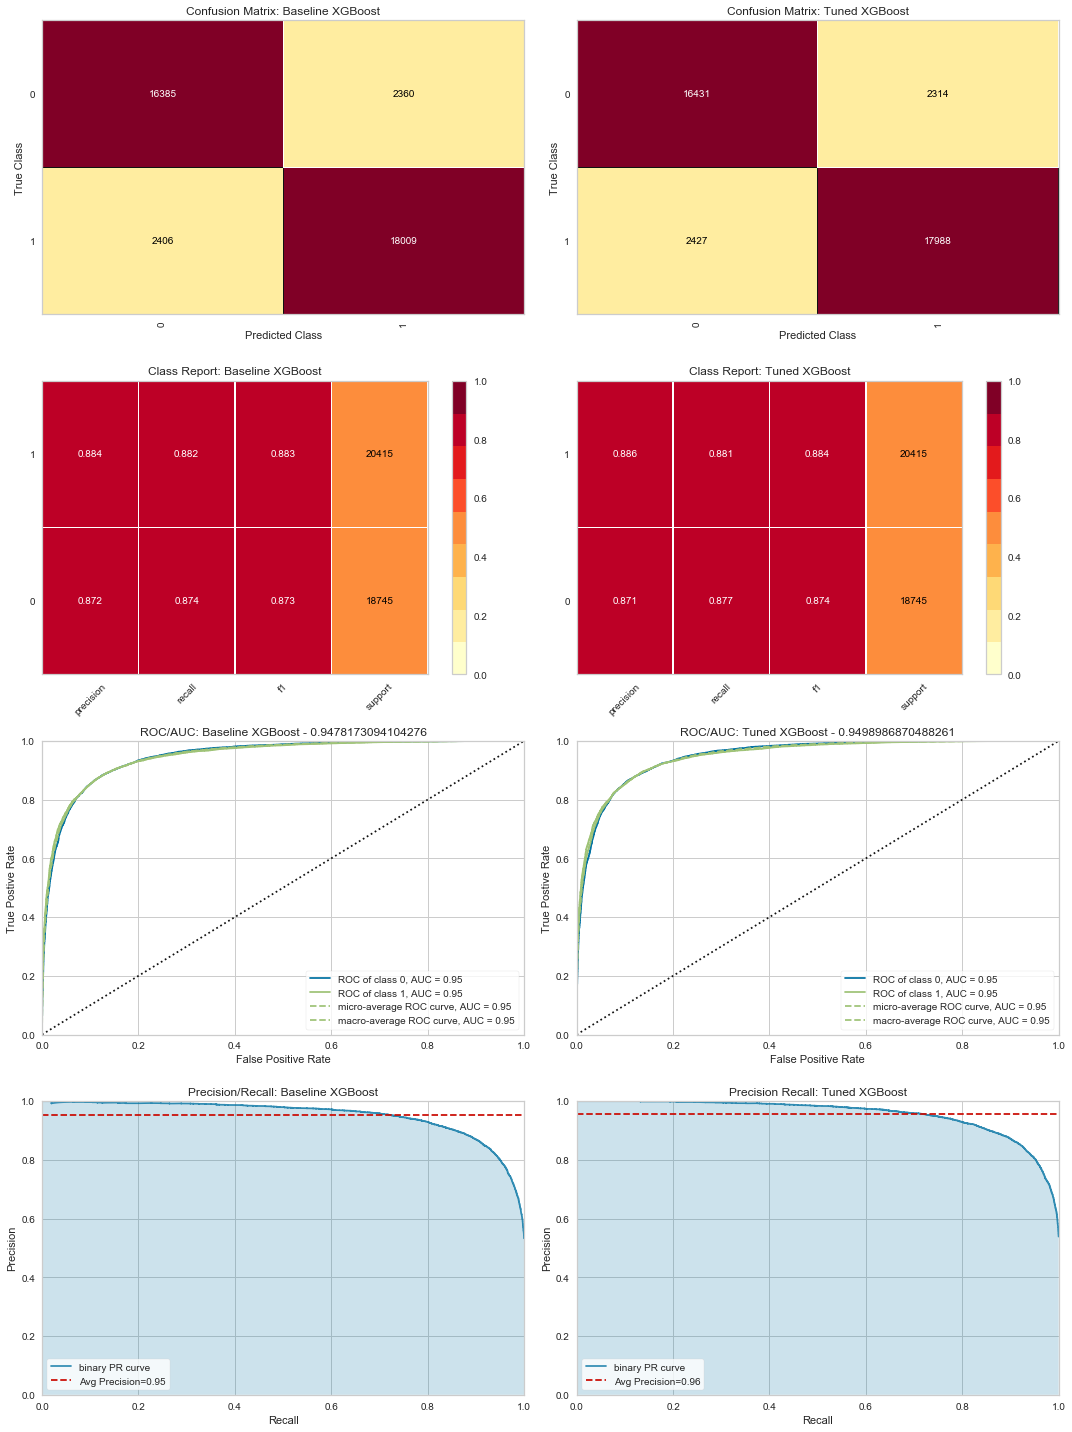

In [404]:
print(baseline_xgboost_fit.best_estimator_)
print(tuned_xgboost_fit.best_estimator_)
compare_classifiers(
     baseline_xgboost_fit.best_estimator_
    , tuned_xgboost_fit.best_estimator_
    , 'Baseline XGBoost'
    , 'Tuned XGBoost'
    , all_train_features
    , all_test_features
    , all_train_target
    , all_test_target)  

## Modeling and Evaluation 5

- Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

## Modeling and Evaluation 6

- Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.